# Imports 

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle 
from sklearn.metrics import accuracy_score 
import torch 
from torch import nn, optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt

# Data Prep

In [12]:
# READ DATA
data = pd.read_excel("default of credit card clients.xls", skiprows=1)

# DROP COLUMNS
data_clean = data.drop(columns=["ID", "SEX"])
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
# CHECK FOR MISSING DATA
total = data_clean.isnull().sum()
percent = (total / data_clean.isnull().count() * 100)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# CHECK FOR OUTLIERS
outliers = {}
for i in range (data_clean.shape[1]):
    min_t = data_clean[data_clean.columns[i]].mean() - (3 * data_clean[data_clean.columns[i]].std())
    max_t = data_clean[data_clean.columns[i]].mean() + (3 * data_clean[data_clean.columns[i]].std())
    count = 0
    for j in data_clean[data_clean.columns[i]]:
        if j < min_t or j > max_t: count +=1
    percentage = count / data_clean.shape[0]
    outliers[data_clean.columns[i]] = "%.3f" % percentage
    print(outliers)

{'LIMIT_BAL': '0.004'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005', 'PAY_2': '0.005'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005', 'PAY_2': '0.005', 'PAY_3': '0.005'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005', 'PAY_2': '0.005', 'PAY_3': '0.005', 'PAY_4': '0.006'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005', 'PAY_2': '0.005', 'PAY_3': '0.005', 'PAY_4': '0.006', 'PAY_5': '0.005'}
{'LIMIT_BAL': '0.004', 'EDUCATION': '0.011', 'MARRIAGE': '0.000', 'AGE': '0.005', 'PAY_0': '0.005', 'PAY

yes %: 22.12 - no %: 77.88000000000001


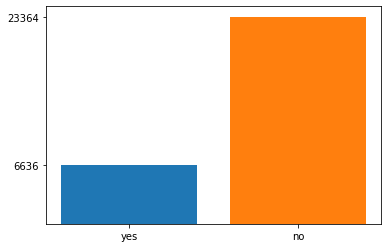

In [18]:
# CLASS IMBALANCE
target = data_clean["default payment next month"]
yes = target[target == 1].count()
no = target[target ==0].count()
print ("yes %: " + str (yes/len(target) * 100) + " - no %: " + str(no/len(target) * 100))

fig, ax = plt.subplots()
plt.bar("yes", yes)
plt.bar("no", no)
ax.set_yticks([yes, no])
plt.show()

In [41]:
# CLASS IMBALANCE FIX
data_yes = data_clean[data_clean["default payment next month"] == 1]
data_no = data_clean[data_clean["default payment next month"] == 0]
over_sampling = data_yes.sample(no, replace=True, random_state=0)
data_resampled = pd.concat([data_no, over_sampling], axis=0)

In [42]:
# SPLIT AND RESCALE
X = data_clean.drop(columns=["default payment next month"])
Y = data_clean["default payment next month"]
X = (X - X.min()) / (X.max() - X.min())
X.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,0.4,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [43]:
# FINAL DATA
final_data = pd.concat([X, Y], axis=1)
final_data.to_csv("dccc_prepared.csv", index=False)

In [45]:
# Read in data from file produced
data = pd.read_csv("dccc_prepared.csv")

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.010101,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,0.0,...,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1
1,0.111111,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,0.4,...,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1
2,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
3,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
4,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,0.2,...,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892,0
29996,0.141414,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,0.2,...,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000,0
29997,0.020202,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,0.2,...,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864,1
29998,0.070707,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,0.1,...,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412,1


In [68]:
X = data.iloc[:, :-1]
Y = data.iloc[:, len(data.columns) - 1]

In [71]:
X_new, X_test, Y_new, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, Y_train, Y_dev = train_test_split(X_new, Y_new, test_size=dev_per, random_state=0)

In [73]:
X_dev_tens = torch.tensor(X_dev.values).float()
Y_dev_tens = torch.tensor(Y_dev.values)
X_test_tens = torch.tensor(X_test.values).float()
Y_test_tens = torch.tensor(Y_test.values)

In [77]:
# Building a classification NN
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 100)
        self.hidden_2 = nn.Linear(100, 100)
        self.hidden_3 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 2)
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden_1(x)))
        z = self.dropout(F.relu(self.hidden_2(z)))
        z = self.dropout(F.relu(self.hidden_3(z)))
        out = F.log_softmax(self.output(z), dim=1) # Prep for the NLLLoss
        return out

In [85]:
# STEP 7
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss() # Using negative log-likelihood loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
batch_size = 128

In [86]:
# STEP 8 
train_losses, dev_losses, train_acc, dev_acc = [], [], [], []
for e in range(epochs):
    X_shuffle, Y_shuffle = shuffle(X_train, Y_train)
    running_loss = 0
    running_acc = 0
    iters = 0
    for i in range(0, len(X_shuffle), batch_size):
        iters += 1
        b = i + batch_size
        X_batch = torch.tensor(X_shuffle.iloc[i:b, :].values).float()
        Y_batch = torch.tensor(Y_shuffle.iloc[i:b].values)
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(Y_batch, top_class)
        
    dev_loss = 0
    acc = 0
    
    with torch.no_grad():
        pred_dev = model(X_dev_tens)
        dev_loss = criterion(pred_dev, Y_dev_tens)
        ps_dev = torch.exp(pred_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(Y_dev_tens, top_class_dev)
        
    train_losses.append(running_loss/iters)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iters)
    dev_acc.append(acc)
    
    print ("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/iters),
            "Validation Loss: {:.3f}.. ".format(dev_loss),
            "Training Accuracy: {:.3f}.. ".format(running_acc/iters),
            "Validation Accuracy: {:.3f}".format(acc))   

Epoch: 1/50..  Training Loss: 0.511..  Validation Loss: 0.471..  Training Accuracy: 0.789..  Validation Accuracy: 0.804
Epoch: 2/50..  Training Loss: 0.461..  Validation Loss: 0.458..  Training Accuracy: 0.809..  Validation Accuracy: 0.806
Epoch: 3/50..  Training Loss: 0.451..  Validation Loss: 0.453..  Training Accuracy: 0.813..  Validation Accuracy: 0.812
Epoch: 4/50..  Training Loss: 0.450..  Validation Loss: 0.452..  Training Accuracy: 0.814..  Validation Accuracy: 0.810
Epoch: 5/50..  Training Loss: 0.447..  Validation Loss: 0.450..  Training Accuracy: 0.815..  Validation Accuracy: 0.812
Epoch: 6/50..  Training Loss: 0.445..  Validation Loss: 0.445..  Training Accuracy: 0.815..  Validation Accuracy: 0.812
Epoch: 7/50..  Training Loss: 0.445..  Validation Loss: 0.446..  Training Accuracy: 0.818..  Validation Accuracy: 0.813
Epoch: 8/50..  Training Loss: 0.443..  Validation Loss: 0.443..  Training Accuracy: 0.817..  Validation Accuracy: 0.816
Epoch: 9/50..  Training Loss: 0.443..  V

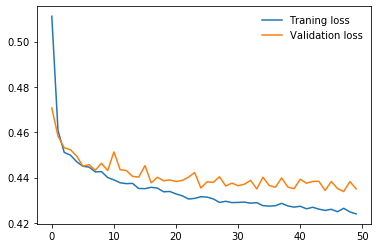

In [87]:
# STEP 9
plt.plot(train_losses, label='Traning loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

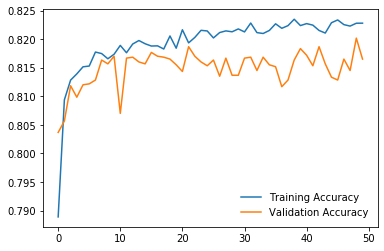

In [88]:
# STEP 10

plt.plot(train_acc, label="Training Accuracy")
plt.plot(dev_acc, label="Validation Accuracy")
plt.legend(frameon=False)
plt.show()